## 2019 Stack Overflow Developer Survey - A Linear Regression Model

In [10]:
#Import modules needed for statistical tests and models

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style 
%matplotlib inline
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import math 
import scipy.stats as stats
from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

In [11]:
#import .csv file from Datacleaning notebook

data = pd.read_csv('dev_df.csv', index_col=0)

In [12]:
#inspect data

data.head()

,Respondent,FullDev,Hobbyist,OpenSourcer,EdLevel,UndergradMajor,DevType,YearsCodePro,FizzBuzz,Salary,WorkWeekHrs,WorkRemote,LanguageWorkedWith,ITperson,Age,Gender,Ethnicity,num_language
0,4,1,0,Never,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...","Developer, full-stack",1,0,61000.0,80.0,Less than once per month / Never,C;C++;C#;Python;SQL,SIGH,22.0,Man,White or of European descent,5
1,13,1,1,Less than once a month but more than once per ...,"Master’s degree (MA, MS, M.Eng., MBA, etc.)","Computer science, computer engineering, or sof...",Data or business analyst;Database administrato...,8,1,90000.0,40.0,All or almost all the time (I'm full-time remote),Bash/Shell/PowerShell;HTML/CSS;JavaScript;PHP;...,Yes,28.0,Man,White or of European descent,6
2,23,1,1,Less than once per year,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Information systems, information technology, o...","Developer, full-stack",1,0,69000.0,40.0,A few days each month,Bash/Shell/PowerShell;HTML/CSS;JavaScript;Pyth...,SIGH,22.0,Man,Black or of African descent,6
4,35,1,0,Never,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Information systems, information technology, o...","Developer, front-end",14,0,80000.0,40.0,Less than once per month / Never,HTML/CSS;JavaScript,"Fortunately, someone else has that title",35.0,Woman,Black or of African descent,2
5,39,1,1,Less than once per year,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...","Database administrator;Developer, back-end;Dev...",23,0,156000.0,50.0,Less than once per month / Never,C#;JavaScript;SQL;TypeScript,Also Yes,42.0,Man,White or of European descent,4


### Intro:

When we see developers and coders in the media, one of the traits that is always associated with them is having a high salary but, are there any variances within the community? Are there other factors that play into an individual's income that differentiate them from other developers? This analysis of the annual survey conducted by Stack Overflow hopes to give us a better understanding of the developer's community. 


### Five Questions to think about:

1. Is there a strong relationship between your salary and your educational background?
2. Is there a linear relationship between years you've coded and salary?
3. Are there any statistical differences amongst the categories of being a full developer or if you've been asked to complete fizzbuzz in an interview?
4. Does the number of langauges you know affect your salary?
5. Does the amount of hours you work affect your income? What if you work remotely?

### Approach

The first step was to clean and filter the data. Across the 90,000 respondents of the survey, I decided to filter by Country (United States only) and Employment (full-time only). I checked the schema data of the survey to handpick which questions I thought would have an impact on a developer's income (dependent variable). <br/>

Questions picked (potential features): <br/>

- Number of years a dev has been coding professionally ('YearsCodePro) <br/>
- Number of language a dev knows ('num_language') <br/>
- Age
- How many hours worked per week ('WorkWeekHrs') <br/>
- Coding at all times during work ('FullDev') <br/>
- Highest education level attained ('EdLevel') <br/>
- UndergradMajor <br/>
- The type of developer ('DevType') <br/>
- WorkRemote <br/>
- Have you been asked to solve 'FizzBuzz' in an interview <br/>
- The languages you work with ('LanguageWorkedWith') <br/>
- Gender <br/>

I seperated the questions on whether they were continuous or categorical. After inspecting the data and relevant columns, I prepped the continuous variables by either filtering out extreme values or using a log transformation. Categorical variables were also transformed into numerical data for better analysis, for example, a "yes" would turn into a 1 and a "no" would turn into a 0. I created a few graphs to visualize the data to understand it better. <br/>

For modeling: First, I only used one feature which seems to have the highest correlation with income. Second, I tested a model with all the features I handpicked. Third, I also used feature selection to enhanced the model to get better results.

In [63]:
#set up the correlation matrix for all columns

corr = data.corr()

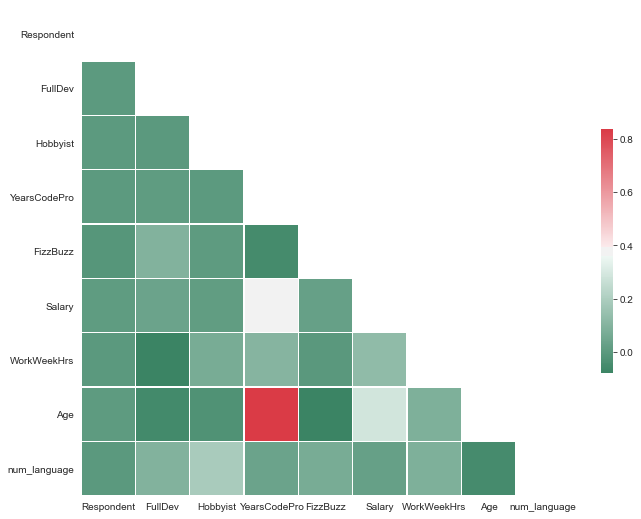

In [14]:
#visualize the correlation matrix using a heatmap 

def CorrMtx(df, dropDuplicates = True):
    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(150, 10, as_cmap=True)
    
    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)

CorrMtx(corr, dropDuplicates = True)

In [ ]:
#Interpreting the heatmap, the only highly correlated features are Age and YearsCodePro
#The rest of the heatmap is fairly green indicating little correlation between each other
#It's safe to say we won't have any multicollinearity problems

### Data Viz #0

Distribution of salary

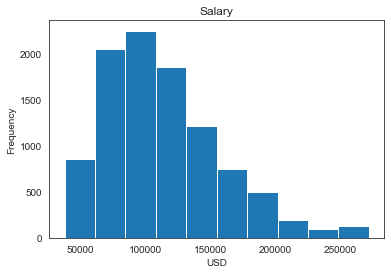

In [15]:
#histogram of salary

data['Salary'].plot(kind='hist')
plt.title('Salary')
plt.xlabel('USD')
plt.show()

In [16]:
#min, median, mean and max of Salary

data['Salary'].min(), data['Salary'].median(), round(data['Salary'].mean()), data['Salary'].max()

(37600.0, 105000.0, 113170.0, 272313.0)

In [ ]:
#the distribution safe of the salary is skewed a bit to the right but still maintains a pretty normal shape

In [17]:
cont = ['YearsCodePro', 'num_language', 'Age', 'WorkWeekHrs'] 
cat = ['FullDev', 'Hobbyist', 'OpenSourcer', 'EdLevel', 'UndergradMajor', 
       'DevType', 'WorkRemote', 'FizzBuzz', 'LanguageWorkedWith', 
       'ITperson', 'Gender', 'Ethnicity']
DV = ['Salary']

### Data Viz #1 

Overview of continuous variables

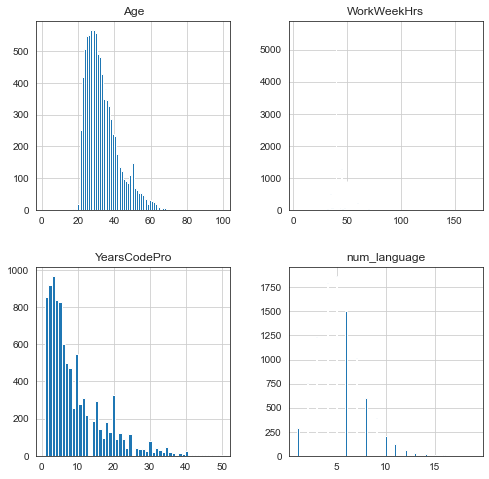

In [18]:
# Distribution of continious vars
continuous = ['YearsCodePro', 'num_language', 'Age', 'WorkWeekHrs']
data_cont = data[continuous]
data_cont.hist(figsize=[8,8], bins='auto')
plt.show()

In [ ]:
#The shape of the continuous variables are also somewhat normal but does still consist of extreme values

### Data Viz #2

Overview of categorical variables

In [179]:
#The average salaries grouped by your undergrad major

data.groupby('UndergradMajor')['Salary'].mean()

UndergradMajor
A business discipline (ex. accounting, finance, marketing)               107559.498462
A health science (ex. nursing, pharmacy, radiology)                      111250.375000
A humanities discipline (ex. literature, history, philosophy)            108281.878866
A natural science (ex. biology, chemistry, physics)                      113197.368526
A social science (ex. anthropology, psychology, political science)       103623.715711
Another engineering discipline (ex. civil, electrical, mechanical)       118845.154192
Computer science, computer engineering, or software engineering          116217.328043
Fine arts or performing arts (ex. graphic design, music, studio art)     105781.013369
I never declared a major                                                 108881.527273
Information systems, information technology, or system administration    103378.499232
Mathematics or statistics                                                118249.438679
Web development or web desig

In [ ]:
#All the majors are pretty similar except for web design

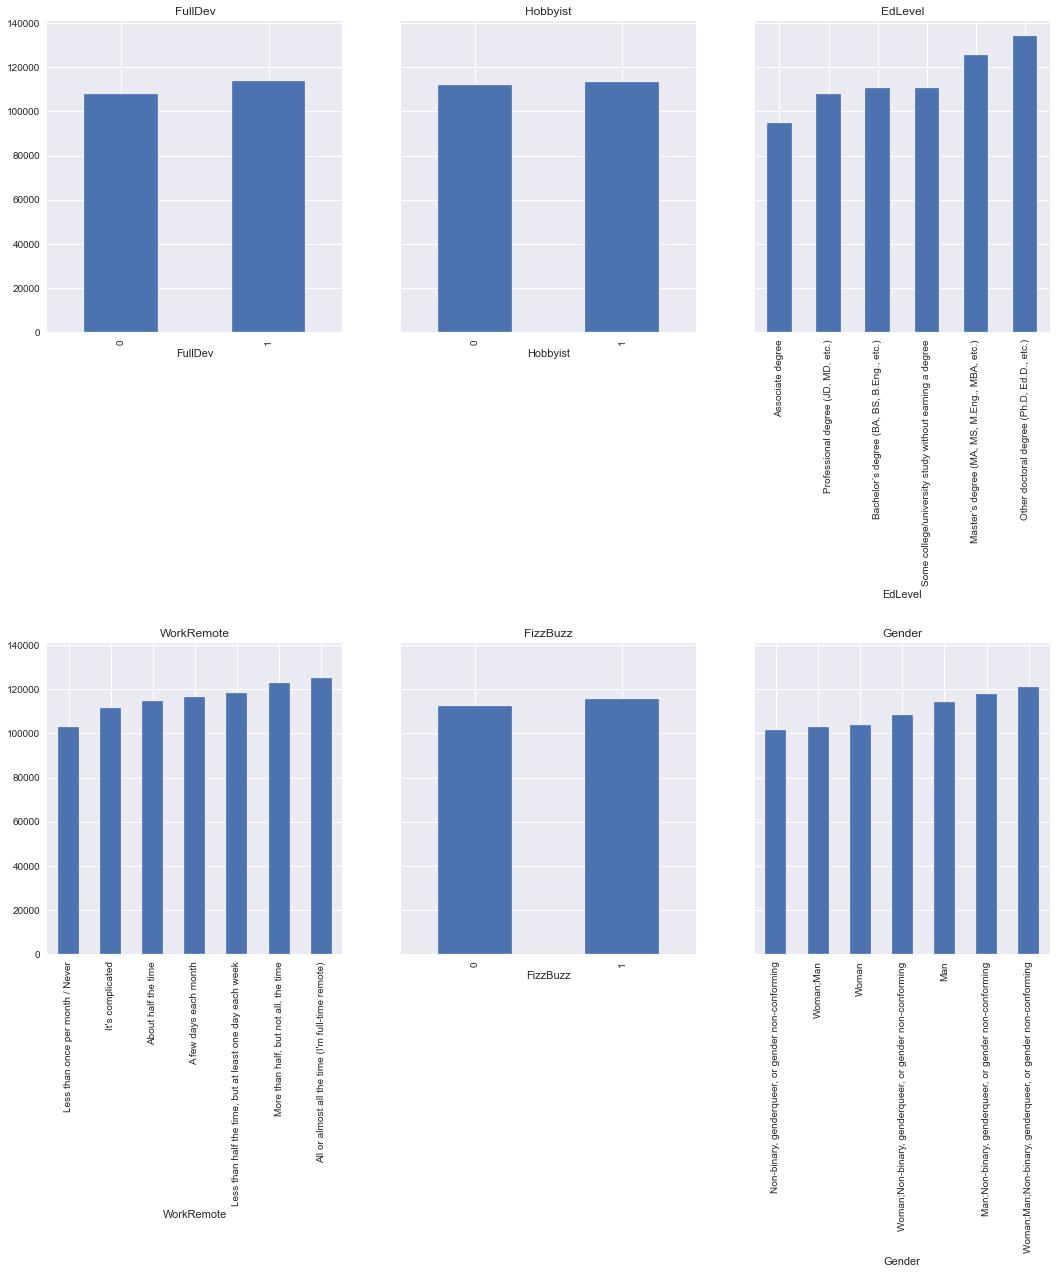

In [192]:
# Create bar plots for categorical data
plt.style.use('seaborn') 
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,16), sharey=True)

categoricals = ['FullDev', 'Hobbyist', 'EdLevel','WorkRemote', 'FizzBuzz','Gender']

for col, ax in zip(categoricals, axes.flatten()):
    (data.groupby(col) #group values together by col of interest
         .mean()['Salary'] #take the mean of the Salary for each group
         .sort_values() #sort the groups in ascending order
         .plot 
         .bar(ax=ax)) #create a bar graph on the ax
    ax.set_title(col)

fig.subplots_adjust(hspace=1)
plt.show()

In [ ]:
#Looking back at our initial questions, the bar graphs gives us an insight on answering them.
#It seems like coding at all times at your job does impact your salary and so does having fizzbuzz as part of your interview process
#Education level and gender also seem to have some type of variance in their average means

### Data Viz #3

Scatter plots / Simple Linear Regressions 

In [ ]:
#Regression Line Code
# m, b = np.polyfit(x, y, 1)
# m = slope, b=intercept
# plt.plot(x, m*x + b)

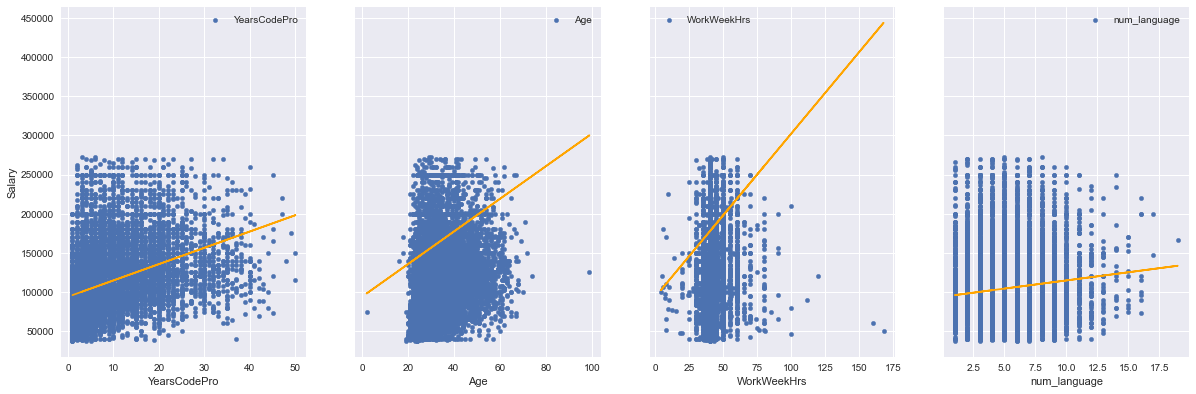

In [258]:
# Visualize the relationship between the preditors and the target using scatterplots
fig2, axs = plt.subplots(1,4, sharey=True, figsize=(18,6))

for idx, pred in enumerate(['YearsCodePro', 'Age', 'WorkWeekHrs', 'num_language']):
    data.plot(kind='scatter', x=pred, y='Salary', ax=axs[idx], label=pred)

for idx, pred in enumerate(['YearsCodePro', 'Age', 'WorkWeekHrs', 'num_language']):
    axs[idx].plot(data[pred], m*data[pred] + b, color='orange')
    
plt.legend()
plt.show()

In [ ]:
#The scatter plots with their respective regression lines tells us the direction of the relationship between
#the continuous variables and our dependent variable but the data is so dense that it's almost random.

### Data Viz #4
Cont and Cat relationship with target

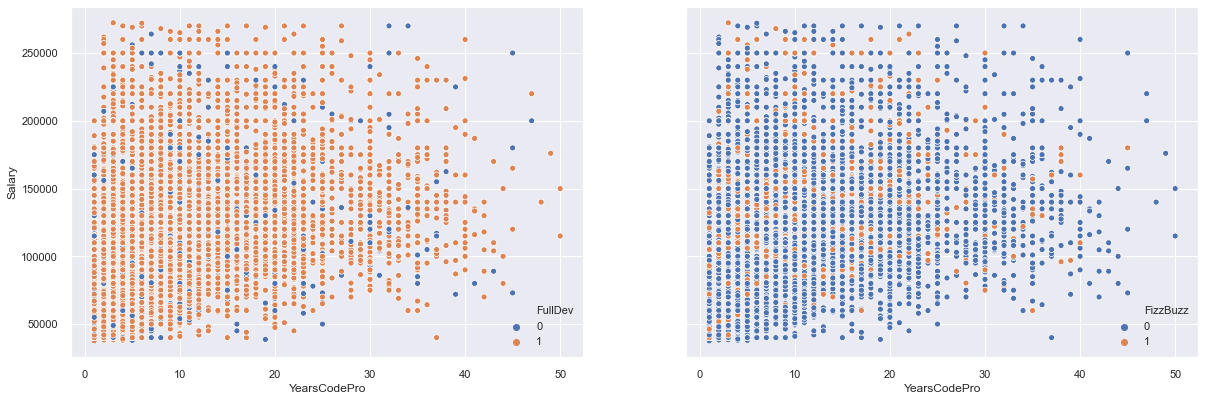

In [322]:
#Cont and Cat relationship with target
fig3, ax3 = plt.subplots(1,2, sharey=True, figsize=(18,6))

sns.scatterplot(x='YearsCodePro', y="Salary",
                     hue="FullDev",
                     data=data, ax=ax3[0])

sns.scatterplot(x='YearsCodePro', y="Salary",
                     hue="FizzBuzz",
                     data=data, ax=ax3[1])

plt.show()

In [ ]:
#We saw that there was a small difference between the average income for developers who code all the time and/or 
#asked about fizzbuzz question but seeing these two visuals here tells us that it could have been random.

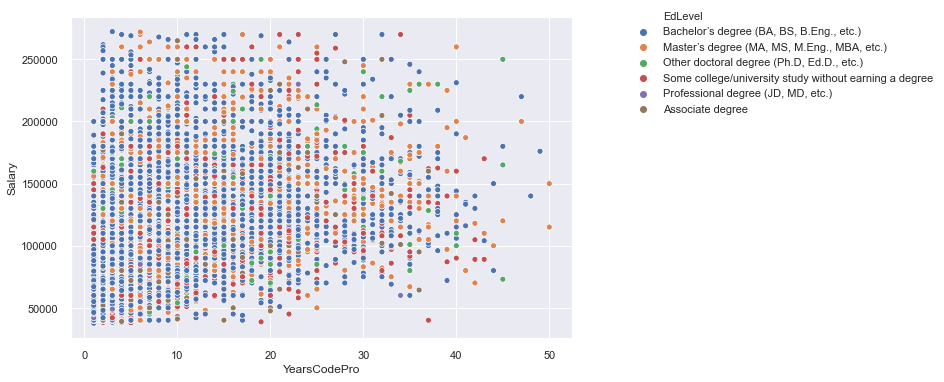

In [354]:
ax = sns.scatterplot(x='YearsCodePro', y="Salary",
                     hue="EdLevel",
                     data=data)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [302]:
#We also asked if education level attained plays a role into one's income. The graph above hints that it may not. 

## STAT TESTS

Comparing population means with different categorical variables 

Null Hypothesis: There is no statistical difference in means between people who code all the time at their job and those who don't.  <br/>

Alternative Hypotehsis: There is a statistical difference in means between people who code all the time at their job and those who don't.  <br/>

In [358]:
#filter fulldev

fulldev_yes = data['FullDev'] == 1
fulldev_no = data['FullDev'] == 0

In [371]:
fulldevyes_salary = data[fulldev_yes]['Salary']
fulldevno_salary = data[fulldev_no]['Salary']
round(fulldevyes_salary.mean()), round(fulldevno_salary.mean())

(113687.0, 107698.0)

In [370]:
#Full Dev Statistic Value
stats.ttest_ind(fulldevyes_salary, fulldevno_salary)

Ttest_indResult(statistic=3.781866175520473, pvalue=0.00015657188624861276)

In [ ]:
#We reject the null hypothesis
#We can interpret that the difference in means between people who code full time and people who don't code full time
#is indeed statiscally different but we can also tell from the previous graph that it may not be a huge difference

Null Hypothesis: There is no statistical difference in means between people who were asked fizzbuzz during an interview and people who were not asked.  <br/>

Alternative Hypotehsis: There is a statistical difference in means between people who were asked fizzbuzz during an interview and people who were not asked.  <br/>

In [372]:
#Filter Fizbuzz
fb_yes = data['FizzBuzz'] == 1
fb_no = data['FizzBuzz'] == 0

In [373]:
fbyes_salary = data[fb_yes]['Salary']
fbno_salary = data[fb_no]['Salary']
round(fbyes_salary.mean()), round(fbno_salary.mean())

(115535.0, 112461.0)

In [374]:
#Fizzbuzz statistic value
stats.ttest_ind(fbyes_salary, fbno_salary)

Ttest_indResult(statistic=2.9086272846059624, pvalue=0.0036382567546787317)

In [ ]:
#We reject the null hypothesis
#Similar to the fulldev, the difference in means of people who had a fizzbuzz interview experience is 
#statiscally different but probably not by much

Null Hypothesis: There is no statistical difference in means between people's level of education.  <br/>

Alternative Hypotehsis: There is a statistical difference in means between people's level of education.  <br/>

In [19]:
#EdLevel
bach  = data['EdLevel'] == 'Bachelor’s degree (BA, BS, B.Eng., etc.)'
mast  = data['EdLevel'] == 'Master’s degree (MA, MS, M.Eng., MBA, etc.)'
phd   = data['EdLevel'] == 'Other doctoral degree (Ph.D, Ed.D., etc.)'
other = data['EdLevel'] == 'Some college/university study without earning a degree'
prof  = data['EdLevel'] == 'Professional degree (JD, MD, etc.)'
assc  = data['EdLevel'] == 'Associate degree'

In [20]:
#average salary between education level
data[bach]['Salary'].mean(), data[mast]['Salary'].mean(), data[phd]['Salary'].mean(), data[other]['Salary'].mean() , data[prof]['Salary'].mean(), data[assc]['Salary'].mean()

(110538.63803877584,
 125451.27990841442,
 134222.1013986014,
 110718.15193133047,
 107801.25,
 94766.91474654379)

In [21]:
# ANOVA of salaries by education level
stats.f_oneway(data[bach]['Salary'], data[mast]['Salary'], data[phd]['Salary'], 
               data[other]['Salary'], data[prof]['Salary'], data[assc]['Salary'])

F_onewayResult(statistic=61.70968227100415, pvalue=1.461992935855373e-63)

In [64]:
#we fail to reject the null hypothesis
#Even if we saw that the bargraph displayed a difference in means, there is no statistical difference in them
#and they may have just been random

### Fun facts related to data science and python:

In [6]:
#data vs SE
developer = data['DevType'].str.contains('Developer')
data_scientist = data['DevType'].str.contains('Data')

In [71]:
print('Number of software developers: ',data[developer]['DevType'].count())
print('Number of data scientists: ', data[data_scientist]['DevType'].count())

Number of software developers:  9021
Number of data scientists:  2076


In [78]:
data[developer]['Salary'].mean(), data[data_scientist]['Salary'].mean()

(112911.02549606474, 108571.90895953757)

In [83]:
#Python 

print('Number of people who know Python in the survey: ', data['LanguageWorkedWith'].str.contains('Python').sum())
print('Percentage of people who know Python', round((data['LanguageWorkedWith'].str.contains('Python').sum() / len(data)), 2))
print('Mean salary of people who know Python', round((data[data['LanguageWorkedWith'].str.contains('Python')]['Salary'].mean()))) 

Number of people who know Python in the survey:  4426
Percentage of people who know Python 0.45
Mean salary of people who know Python 116605.0


### Simple Linear Regression Model 

Relationship between salary and years coding

In [22]:
# building the formula 

f = 'Salary~YearsCodePro'

# create a fitted model in one line
model = ols(formula=f, data=data).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     1692.
Date:                Thu, 07 May 2020   Prob (F-statistic):               0.00
Time:                        11:13:13   Log-Likelihood:            -1.1935e+05
No. Observations:                9913   AIC:                         2.387e+05
Df Residuals:                    9911   BIC:                         2.387e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     9.398e+04    622.168    151.053      0.000    9.28e+04    9.52e+04
YearsCodePro  2082.5238     50.631     41.131      0.000    1983.276    2181.772
==============================================================================
Omnibus:                     1378.319   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2149.533
Skew:                           0.980   Prob(JB):                         0.00
Kurtosis:                       4.166   Cond. No.                         18.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#Using YearsCodePro as the only feature gives us an R^2 value of .146 meaning it does not explain the variance of 
#salaries so well but given it's p-value of 0, it is still statistically significant.

In [62]:
#testing simple linear regression 

X = data_fin[['YearsCodePro']]
y = data_fin[['Salary']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: Salary    1.595440e+09
dtype: float64
Test Mean Squarred Error: Salary    1.565820e+09
dtype: float64


In [ ]:
#testing this model using MSE as a metric, both are train and test datasets had similar results 
#or an error of about $40k

### Setting up for dummy variables

In [24]:
#cleaning up categoricals
data['education'] = data['EdLevel']

data['education'].replace({'Bachelor’s degree (BA, BS, B.Eng., etc.)': 'bach', 
                           'Master’s degree (MA, MS, M.Eng., MBA, etc.)': 'mast',
                           'Other doctoral degree (Ph.D, Ed.D., etc.)': 'phd',
                           'Some college/university study without earning a degree': 'other',
                           'Professional degree (JD, MD, etc.)': 'prof',
                           'Associate degree': 'assc'}, inplace=True)

In [25]:
#simpliflying the undergradmajor column because there are white spaces in the values

data['major'] = data['UndergradMajor'] 

data['major'].replace({'Computer science, computer engineering, or software engineering': 'cs', 
                       'Information systems, information technology, or system administration': 'it',
                       'Another engineering discipline (ex. civil, electrical, mechanical)': 'engineer',
                       'Mathematics or statistics': 'math',
                       'A humanities discipline (ex. literature, history, philosophy)': 'humanities',
                       'A social science (ex. anthropology, psychology, political science)': 'socsci',
                       'Web development or web design': 'web',
                       'I never declared a major': 'none',
                       'Fine arts or performing arts (ex. graphic design, music, studio art)': 'fineart',
                       'A business discipline (ex. accounting, finance, marketing)': 'business',
                       'A natural science (ex. biology, chemistry, physics)': 'natsci',
                       'A health science (ex. nursing, pharmacy, radiology)': 'healthsci',}, inplace=True)

In [26]:
#transforming workremote column into binary, it's either you work fully remote or you don't 

data['remote'] = data['WorkRemote']

data['remote'].replace({'Less than once per month / Never': 0, 
                        "All or almost all the time (I'm full-time remote)": 1,
                        'A few days each month': 0,
                        'About half the time': 0,
                        "It's complicated": 0,
                        'Less than half the time, but at least one day each week': 0,
                        'More than half, but not all, the time': 0,}, inplace=True)

In [27]:
#gender column is also simpliflied into three groups 

data['gen'] = data['Gender']

data['gen'].replace({'Non-binary, genderqueer, or gender non-conforming': 'nonbinary', 
                        'Woman;Non-binary, genderqueer, or gender non-conforming': 'nonbinary',
                        'Woman;Man': 'both',
                        'Man;Non-binary, genderqueer, or gender non-conforming': 'nonbinary',
                        'Woman;Man;Non-binary, genderqueer, or gender non-conforming': 'nonbinary',}, inplace=True)

### Modeling

Multi-variate linear regression

In [28]:
# Scaler
scaler = StandardScaler()

In [29]:
# Prepare data for model

# log continuous features 
logyears = np.log(data[['YearsCodePro']])
lognumlang = np.log(data[['num_language']])
logworkhrs= np.log(data[['WorkWeekHrs']])

In [30]:
#nonlogged continuous features
yearsnormal = data['YearsCodePro']
numlangnormal = data['num_language']
workhrsnormal = data['WorkWeekHrs']

In [31]:
#scaling nonloggeddata
scaled_yearsnormal = scaler.fit_transform(data[['YearsCodePro']])
scaled_numlangnormal = scaler.fit_transform(data[['num_language']])
scaled_workhrsnormal = scaler.fit_transform(data[['WorkWeekHrs']])

In [32]:
# Create a dataframe with only normal features
data_normal = pd.DataFrame([])

In [33]:
# Create a dataframe with scaled normal features
data_scale = pd.DataFrame([])
data_scale['yearscodednormal'] = scaled_yearsnormal.flatten()
data_scale['numlangnormal'] = scaled_numlangnormal.flatten()
data_scale['workhrsnormal'] = scaled_workhrsnormal.flatten()

In [34]:
# Create a dataframe with logged features
data_fin = pd.DataFrame([])

In [35]:
# Create dummies for categorical features
edlevel_dummies = pd.get_dummies(data['education'], prefix='ed', drop_first=True)
major_dummies = pd.get_dummies(data['major'], prefix='maj', drop_first=True)
gender_dummies = pd.get_dummies(data['gen'], prefix='gen', drop_first=True)

In [36]:
#binary categorical features

remote = data['remote']
fulldev = data['FullDev']
hobby = data['Hobbyist']
fb = data['FizzBuzz']

In [37]:
#Salary as the dependent variable
salary = data['Salary']

### Creation of Models

In [38]:
# Concat with dataframe normal model
data_normal = pd.concat([salary, yearsnormal, numlangnormal, workhrsnormal,  fulldev, hobby, fb, 
                      edlevel_dummies, remote, gender_dummies, major_dummies], axis=1)

In [39]:
#Normal model
dv = 'Salary'
iv = data_normal.drop('Salary', axis=1)
pred_sum = '+'.join(iv.columns)
formula = dv + '~' + pred_sum
model = ols(formula=formula, data=data_normal).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     90.94
Date:                Thu, 07 May 2020   Prob (F-statistic):               0.00
Time:                        11:14:38   Log-Likelihood:            -1.1907e+05
No. Observations:                9913   AIC:                         2.382e+05
Df Residuals:                    9886   BIC:                         2.384e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       4.284e+04   4294.136      9.976      0.000    3.44e+04    5.13e+04
YearsCodePro    1914.5349     51.410     37.241      0.000    1813.761    2015.309
num_language      30.0074    178.759      0.168      0.867    -320.397     380.412
WorkWeekHrs      595.2798     62.766      9.484      0.000     472.247     718.313
FullDev         6684.5316   1485.737      4.499      0.000    3772.183    9596.880
Hobbyist         237.4073   1013.363      0.234      0.815   -1748.992    2223.806
FizzBuzz        5158.0032    963.170      5.355      0.000    3269.994    7046.012
ed_bach         1.476e+04   2018.940      7.309      0.000    1.08e+04    1.87e+04
ed_mast         2.552e+04   2189.612     11.654      0.000    2.12e+04    2.98e+04
ed_other        9362.6162   2278.573      4.109      0.000    4896.148    1.38e+04
ed_phd          3.182e+04   3177.858     10.012      0.000    2.56e+04     3.8e+04
ed_prof         7858.2928   6648.687      1.182      0.237   -5174.490    2.09e+04
remote          8183.0609   1201.644      6.810      0.000    5827.594    1.05e+04
gen_Woman      -3289.1141   1379.787     -2.384      0.017   -5993.779    -584.449
gen_both       -2418.0543      2e+04     -0.121      0.904   -4.16e+04    3.67e+04
gen_nonbinary  -2150.9522   3205.305     -0.671      0.502   -8434.004    4132.099
maj_cs          5884.5862   2285.512      2.575      0.010    1404.517    1.04e+04
maj_engineer    3739.0894   2710.019      1.380      0.168   -1573.101    9051.280
maj_fineart    -1136.9823   3034.992     -0.375      0.708   -7086.185    4812.220
maj_healthsci   1.105e+04   8482.317      1.302      0.193   -5579.739    2.77e+04
maj_humanities   739.4855   3010.601      0.246      0.806   -5161.907    6640.878
maj_it         -4674.4048   2715.252     -1.722      0.085   -9996.852     648.042
maj_math        6929.3159   2955.436      2.345      0.019    1136.059    1.27e+04
maj_natsci      1908.5948   2880.234      0.663      0.508   -3737.252    7554.442
maj_none         267.7218   3947.606      0.068      0.946   -7470.391    8005.835
maj_socsci     -1398.3446   2995.199     -0.467      0.641   -7269.545    4472.856
maj_web        -1.177e+04   3362.749     -3.499      0.000   -1.84e+04   -5175.564
==============================================================================
Omnibus:                     1417.119   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2290.160
Skew:                           0.982   Prob(JB):                         0.00
Kurtosis:                       4.300   Cond. No.                     2.20e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The conditio

In [ ]:
#a linear regression model without any feature engineering gives us an adjusted R^2 of .191
#not much of an improvement from our single linear regression model

In [40]:
# Concat with dataframe normal+scale model
data_scale = pd.concat([salary, data_scale,  fulldev, hobby, fb, 
                      edlevel_dummies, remote, gender_dummies, major_dummies], axis=1)

In [41]:
#Normal+Scale model
dv = 'Salary'
iv = data_scale.drop('Salary', axis=1)
pred_sum = '+'.join(iv.columns)
formula = dv + '~' + pred_sum
model = ols(formula=formula, data=data_scale).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     24.18
Date:                Thu, 07 May 2020   Prob (F-statistic):          1.74e-111
Time:                        11:14:47   Log-Likelihood:            -1.0355e+05
No. Observations:                8569   AIC:                         2.071e+05
Df Residuals:                    8542   BIC:                         2.073e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         8.339e+04   3855.022     21.632      0.000    7.58e+04    9.09e+04
yearscodednormal   342.5719    464.269      0.738      0.461    -567.508    1252.651
numlangnormal      -59.1704    465.341     -0.127      0.899    -971.352     853.011
workhrsnormal      298.5985    468.850      0.637      0.524    -620.460    1217.657
FullDev           9032.0910   1718.268      5.257      0.000    5663.870    1.24e+04
Hobbyist          -420.1592   1148.441     -0.366      0.714   -2671.382    1831.063
FizzBuzz          3076.8257   1108.282      2.776      0.006     904.326    5249.326
ed_bach           1.333e+04   2371.827      5.620      0.000    8680.473     1.8e+04
ed_mast            2.85e+04   2566.651     11.102      0.000    2.35e+04    3.35e+04
ed_other          1.279e+04   2660.421      4.806      0.000    7571.680     1.8e+04
ed_phd            4.482e+04   3732.113     12.011      0.000    3.75e+04    5.21e+04
ed_prof           1.985e+04   7668.401      2.589      0.010    4819.814    3.49e+04
remote            1.487e+04   1378.190     10.789      0.000    1.22e+04    1.76e+04
gen_Woman        -9882.9013   1579.089     -6.259      0.000    -1.3e+04   -6787.504
gen_both         -1.191e+04   2.48e+04     -0.480      0.631   -6.06e+04    3.67e+04
gen_nonbinary    -8820.6656   3659.660     -2.410      0.016    -1.6e+04   -1646.847
maj_cs            6726.6611   2657.620      2.531      0.011    1517.084    1.19e+04
maj_engineer      8645.0955   3155.414      2.740      0.006    2459.721    1.48e+04
maj_fineart       -956.4457   3516.173     -0.272      0.786   -7848.996    5936.104
maj_healthsci     1111.2490   9999.212      0.111      0.912   -1.85e+04    2.07e+04
maj_humanities    -849.6707   3490.543     -0.243      0.808   -7691.979    5992.638
maj_it           -5392.7138   3154.561     -1.709      0.087   -1.16e+04     790.988
maj_math          5494.9917   3434.082      1.600      0.110   -1236.639    1.22e+04
maj_natsci        -551.8337   3352.200     -0.165      0.869   -7122.957    6019.289
maj_none          2202.7953   4542.199      0.485      0.628   -6701.014    1.11e+04
maj_socsci       -4598.2485   3476.129     -1.323      0.186   -1.14e+04    2215.805
maj_web          -1.341e+04   3957.372     -3.388      0.001   -2.12e+04   -5649.497
==============================================================================
Omnibus:                     1013.451   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1437.207
Skew:                           0.915   Prob(JB):                         0.00
Kurtosis:                       3.824   Cond. No.                         99.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance m

In [ ]:
#a linear regression model scaling our values gives us an adjusted R^2 of .066
#which worsen our explanation of variance

In [42]:
# Concat with dataframe logged model
data_fin = pd.concat([salary, logyears, lognumlang, logworkhrs,  fulldev, hobby, fb, 
                      edlevel_dummies, remote, gender_dummies, major_dummies], axis=1)

In [43]:
#Logged Cont Model

dv = 'Salary'
iv = data_fin.drop('Salary', axis=1)
pred_sum = '+'.join(iv.columns)
formula = dv + '~' + pred_sum
model = ols(formula=formula, data=data_fin).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     115.8
Date:                Thu, 07 May 2020   Prob (F-statistic):               0.00
Time:                        11:14:52   Log-Likelihood:            -1.1881e+05
No. Observations:                9913   AIC:                         2.377e+05
Df Residuals:                    9886   BIC:                         2.379e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -3.677e+04   1.05e+04     -3.507      0.000   -5.73e+04   -1.62e+04
YearsCodePro     1.94e+04    434.377     44.664      0.000    1.85e+04    2.03e+04
num_language   -1420.1724    810.658     -1.752      0.080   -3009.228     168.883
WorkWeekHrs     2.469e+04   2663.697      9.270      0.000    1.95e+04    2.99e+04
FullDev         6012.6789   1450.075      4.146      0.000    3170.235    8855.123
Hobbyist         341.0955    987.610      0.345      0.730   -1594.821    2277.012
FizzBuzz        4150.7300    937.493      4.427      0.000    2313.052    5988.408
ed_bach         1.487e+04   1967.498      7.560      0.000     1.1e+04    1.87e+04
ed_mast          2.43e+04   2134.898     11.384      0.000    2.01e+04    2.85e+04
ed_other        9592.6517   2219.866      4.321      0.000    5241.261    1.39e+04
ed_phd          2.956e+04   3098.800      9.539      0.000    2.35e+04    3.56e+04
ed_prof         9372.8758   6479.506      1.447      0.148   -3328.277    2.21e+04
remote          5850.6267   1175.885      4.976      0.000    3545.653    8155.601
gen_Woman      -1427.7740   1347.495     -1.060      0.289   -4069.138    1213.590
gen_both        -702.5472   1.95e+04     -0.036      0.971   -3.89e+04    3.75e+04
gen_nonbinary  -1862.7636   3123.576     -0.596      0.551   -7985.610    4260.083
maj_cs          3814.1247   2228.420      1.712      0.087    -554.033    8182.282
maj_engineer    3128.5038   2640.693      1.185      0.236   -2047.793    8304.801
maj_fineart    -3530.5136   2959.192     -1.193      0.233   -9331.133    2270.106
maj_healthsci   9537.5197   8266.388      1.154      0.249   -6666.286    2.57e+04
maj_humanities  -721.0223   2934.237     -0.246      0.806   -6472.725    5030.681
maj_it         -7329.9516   2647.307     -2.769      0.006   -1.25e+04   -2140.691
maj_math        6997.8886   2880.462      2.429      0.015    1351.596    1.26e+04
maj_natsci      1243.2554   2806.915      0.443      0.658   -4258.871    6745.382
maj_none       -2377.3618   3848.470     -0.618      0.537   -9921.148    5166.425
maj_socsci     -1705.8847   2918.732     -0.584      0.559   -7427.195    4015.425
maj_web        -1.545e+04   3278.143     -4.714      0.000   -2.19e+04   -9026.220
==============================================================================
Omnibus:                     1483.376   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2460.134
Skew:                           1.007   Prob(JB):                         0.00
Kurtosis:                       4.378   Cond. No.                         240.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#a linear regression model with feature engineering (log transformations) gives us an adjusted R^2 of .231
#which improves our  model slightly

In [44]:
#test logged cont model

X = data_fin.drop('Salary', axis=1)
y = data_fin['Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 1514605154.7387402
Test Mean Squarred Error: 1480131008.6818027


In [ ]:
#testing this model, we get similar values for train and test data with an error of about $39k
#not much lower than our original model 

### Feature Selection

In [ ]:
#Using Stepwise Selection

In [45]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [46]:
X = data_fin.drop('Salary', axis=1)
y = data_fin['Salary']

result = stepwise_selection(X, y, verbose = True)
print('resulting features:')
print(result)

Add  YearsCodePro                   with p-value 0.0
Add  ed_mast                        with p-value 3.99217e-25
Add  WorkWeekHrs                    with p-value 2.52054e-20
Add  maj_web                        with p-value 1.19275e-17
Add  maj_it                         with p-value 9.80664e-13
Add  ed_phd                         with p-value 1.1334e-08
Add  ed_bach                        with p-value 4.18124e-14
Add  FullDev                        with p-value 1.14355e-06
Add  remote                         with p-value 1.36661e-06
Add  FizzBuzz                       with p-value 1.22018e-05
Add  ed_other                       with p-value 9.64401e-05
Add  maj_cs                         with p-value 0.000993824
Add  maj_math                       with p-value 0.000811099
resulting features:
['YearsCodePro', 'ed_mast', 'WorkWeekHrs', 'maj_web', 'maj_it', 'ed_phd', 'ed_bach', 'FullDev', 'remote', 'FizzBuzz', 'ed_other', 'maj_cs', 'maj_math']


In [47]:
X_fin = X[result]
X_with_intercept = sm.add_constant(X_fin)
stepwisemodel = sm.OLS(y, X_with_intercept).fit()
stepwisemodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     230.0
Date:                Thu, 07 May 2020   Prob (F-statistic):               0.00
Time:                        11:15:53   Log-Likelihood:            -1.1882e+05
No. Observations:                9913   AIC:                         2.377e+05
Df Residuals:                    9899   BIC:                         2.378e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3.875e+04   1.02e+04     -3.804      0.000   -5.87e+04   -1.88e+04
YearsCodePro  1.947e+04    428.078     45.477      0.000    1.86e+04    2.03e+04
ed_mast       2.382e+04   2045.169     11.646      0.000    1.98e+04    2.78e+04
WorkWeekHrs   2.493e+04   2649.706      9.408      0.000    1.97e+04    3.01e+04
maj_web      -1.562e+04   2568.243     -6.082      0.000   -2.07e+04   -1.06e+04
maj_it       -7387.2237   1699.958     -4.346      0.000   -1.07e+04   -4054.961
ed_phd        2.965e+04   2985.358      9.932      0.000    2.38e+04    3.55e+04
ed_bach       1.416e+04   1877.585      7.539      0.000    1.05e+04    1.78e+04
FullDev       5697.9989   1441.849      3.952      0.000    2871.681    8524.317
remote        5677.8323   1173.070      4.840      0.000    3378.376    7977.289
FizzBuzz      4003.8865    935.080      4.282      0.000    2170.939    5836.834
ed_other      8482.2311   2136.166      3.971      0.000    4294.911    1.27e+04
maj_cs        3755.9882    916.674      4.097      0.000    1959.121    5552.855
maj_math      6808.7485   2032.455      3.350      0.001    2824.724    1.08e+04
==============================================================================
Omnibus:                     1488.506   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2474.295
Skew:                           1.009   Prob(JB):                         0.00
Kurtosis:                       4.385   Cond. No.                         121.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#the stepwise selection model reduces our features from 26 to 13 without sacrificing our adjusted R^2 
#which makes for a simpler better model

In [57]:
#Test stepwise model

X = X_fin
y = salary

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 1517415027.5575671
Test Mean Squarred Error: 1480795795.221117


In [ ]:
#testing the model using MSE still gives us an error of about $38k 

### Adding Interactions

In [48]:
#create a baseline to measure interaction improvements

regression = LinearRegression()

crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))

baseline

0.22922097716605236

In [59]:
# code to find top interactions by R^2 value here

interactions = []

feat_combinations = combinations(X.columns, 2)

data_copy = X.copy()
for i, (a,b) in enumerate(feat_combinations):
    data_copy['interaction'] = data_copy[a]*data_copy[b]
    score = np.mean(cross_val_score(regression, data_copy, y, scoring='r2', cv=crossvalidation))
    if score > baseline:
         interactions.append((a,b, round(score,3)))

print('Top 3 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:3])
                

Top 3 interactions: [('ed_phd', 'FullDev', 0.232), ('YearsCodePro', 'FizzBuzz', 0.231), ('ed_phd', 'maj_cs', 0.231)]


In [49]:
topinter = '+YearsCodePro*gen_Woman+YearsCodePro*FizzBuzz+FullDev*ed_phd'

In [60]:
data_copy

,YearsCodePro,ed_mast,WorkWeekHrs,maj_web,maj_it,ed_phd,ed_bach,FullDev,remote,FizzBuzz,ed_other,maj_cs,maj_math,interaction
0,0.000000,0,4.382027,0,0,0,1,1,0,0,0,1,0,0
1,2.079442,1,3.688879,0,0,0,0,1,1,1,0,1,0,0
2,0.000000,0,3.688879,0,1,0,1,1,0,0,0,0,0,0
4,2.639057,0,3.688879,0,1,0,1,1,0,0,0,0,0,0
5,3.135494,0,3.912023,0,0,0,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11478,1.791759,0,3.583519,0,0,0,0,1,0,1,1,1,0,0
11479,1.609438,0,3.761200,0,0,0,1,1,0,0,0,1,0,0
11480,2.397895,0,3.555348,0,0,0,1,1,0,0,0,0,0,0
11482,0.693147,0,3.688879,0,0,0,1,1,0,0,0,1,0,0


In [50]:
#Model using stepwise with interaction terms

dv = 'Salary'
iv = data_fin.drop('Salary', axis=1)
predict_sum = '+'.join(result)
formula = dv + '~' + predict_sum
finalmodel = ols(formula=formula+topinter, data=data_fin).fit()
finalmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     182.2
Date:                Thu, 07 May 2020   Prob (F-statistic):               0.00
Time:                        11:16:20   Log-Likelihood:            -1.1878e+05
No. Observations:                9913   AIC:                         2.376e+05
Df Residuals:                    9895   BIC:                         2.377e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -3.366e+04   1.02e+04     -3.303      0.001   -5.36e+04   -1.37e+04
YearsCodePro            1.936e+04    494.084     39.187      0.000    1.84e+04    2.03e+04
ed_mast                 2.393e+04   2038.411     11.738      0.000    1.99e+04    2.79e+04
WorkWeekHrs             2.415e+04   2642.255      9.140      0.000     1.9e+04    2.93e+04
maj_web                -1.516e+04   2559.061     -5.923      0.000   -2.02e+04   -1.01e+04
maj_it                 -7377.5143   1698.167     -4.344      0.000   -1.07e+04   -4048.761
ed_phd                  1.371e+04   4469.495      3.068      0.002    4950.268    2.25e+04
ed_bach                 1.451e+04   1870.728      7.754      0.000    1.08e+04    1.82e+04
FullDev                 3322.7442   1503.371      2.210      0.027     375.830    6269.658
remote                  5528.4270   1169.175      4.728      0.000    3236.605    7820.249
FizzBuzz               -4555.0865   2098.931     -2.170      0.030   -8669.419    -440.754
ed_other                8442.2082   2127.955      3.967      0.000    4270.982    1.26e+04
maj_cs                  3860.6435    921.162      4.191      0.000    2054.978    5666.309
maj_math                7029.2635   2026.444      3.469      0.001    3057.020     1.1e+04
gen_Woman               1.121e+04   2442.616      4.590      0.000    6424.194     1.6e+04
YearsCodePro:gen_Woman -8611.4374   1403.076     -6.138      0.000   -1.14e+04   -5861.122
YearsCodePro:FizzBuzz   4757.9334   1046.447      4.547      0.000    2706.683    6809.184
FullDev:ed_phd          2.474e+04   5005.873      4.941      0.000    1.49e+04    3.45e+04
==============================================================================
Omnibus:                     1517.172   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2550.271
Skew:                           1.020   Prob(JB):                         0.00
Kurtosis:                       4.418   Cond. No.                         122.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#The interaction terms improves our model's adjusted R^2 by .005 which is not significant enough to add them

## Conclusion

Final model: Stepwise Selection Model

In [665]:
stepwisemodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     230.0
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        21:35:12   Log-Likelihood:            -1.1882e+05
No. Observations:                9913   AIC:                         2.377e+05
Df Residuals:                    9899   BIC:                         2.378e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3.875e+04   1.02e+04     -3.804      0.000   -5.87e+04   -1.88e+04
YearsCodePro  1.947e+04    428.078     45.477      0.000    1.86e+04    2.03e+04
ed_mast       2.382e+04   2045.169     11.646      0.000    1.98e+04    2.78e+04
WorkWeekHrs   2.493e+04   2649.706      9.408      0.000    1.97e+04    3.01e+04
maj_web      -1.562e+04   2568.243     -6.082      0.000   -2.07e+04   -1.06e+04
maj_it       -7387.2237   1699.958     -4.346      0.000   -1.07e+04   -4054.961
ed_phd        2.965e+04   2985.358      9.932      0.000    2.38e+04    3.55e+04
ed_bach       1.416e+04   1877.585      7.539      0.000    1.05e+04    1.78e+04
FullDev       5697.9989   1441.849      3.952      0.000    2871.681    8524.317
remote        5677.8323   1173.070      4.840      0.000    3378.376    7977.289
FizzBuzz      4003.8865    935.080      4.282      0.000    2170.939    5836.834
ed_other      8482.2311   2136.166      3.971      0.000    4294.911    1.27e+04
maj_cs        3755.9882    916.674      4.097      0.000    1959.121    5552.855
maj_math      6808.7485   2032.455      3.350      0.001    2824.724    1.08e+04
==============================================================================
Omnibus:                     1488.506   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2474.295
Skew:                           1.009   Prob(JB):                         0.00
Kurtosis:                       4.385   Cond. No.                         121.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [77]:
#min, median, mean and max of Salary

data['Salary'].min(), data['Salary'].median(), round(data['Salary'].mean()), data['Salary'].max()

(37600.0, 105000.0, 113170.0, 272313.0)

I chose the stepwise selection model as my final model because it had the least features (13) without sacrificing too much of the adjusted R^2 compared to the other models. The stepwise function also chooses features with the lowest p-value deeming them statistically significant. The difference in adjusted R^2 with all the other models were less than 1%. The final model had an adjusted R^2 of .231 and an error around 38k USD considering that the mean salary is 113K USD. Here are some takeaways using the model's coefficients: <br/>

- An increase of unit in YearsCodePro also increases income by about 19k USD  <br/>  
- People who worked fully remote make about 5k USD more on average than people who don't <br/>
- The same can be said about education; with a master's and phd, we see an increase of 23k USD and 30k USD on average respectively <br/>
- Developers who've been asked FizzBuzz on an interview makes 4k USD more on average <br/>

#### Further Analysis: 

From looking at the overall data and numerous visualizations, the features selected were not the best indicators of income. With such a low adjusted R^2 and a fairly high standard of error, we cannot explain the salary's variance with high confidence. The differences between the means of the features used on the model were surprisingly trivial. It seems like there are other factors that play into a developer's income. <br/>

Other features to look into for the future are industry type, company size, start up vs non-start up, and seniority in the company. These might have a bigger impact on a developer's income.
